In [1]:
from pyspark.sql import SparkSession
import os
from search import Search
from plotting import Plotting

os.environ["PYTHONUNBUFFERED"] = "1"
# os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"

In [2]:
#dataset_dir = 'large'
dataset_dir = 'ml-latest-small'

In [3]:
def read(spark):
    datasets = {}
    for dataset in os.listdir(dataset_dir):
        data = spark.read.option("header", True).format("csv").load(os.path.join(os.getcwd(),dataset_dir,dataset))
        datasets[dataset.split('.')[0]]=data
    return datasets

In [4]:
spark = SparkSession.builder.master("local").appName("Movies").config("conf-key", "conf-value").getOrCreate()
datasets = read(spark)

In [5]:
search = Search(datasets, spark)
plotting = Plotting(search)

Cache the tables for user and movie Ids that will be used frequently

In [6]:
search.cache_user('1')
search.cache_movie('1')
search.cache_movie_string('1995')

Search user by id, show the number of movies/genre that he/she has watched. This also caches the collected dataframe.

In [7]:
import datetime
start = datetime.datetime.now()
search.search_user_movies('1').show()
uncached_time = datetime.datetime.now()-start

+------+-------+------+---------+-------+--------------------+--------------------+
|userId|movieId|rating|timestamp|movieId|               title|              genres|
+------+-------+------+---------+-------+--------------------+--------------------+
|     1|      1|   4.0|964982703|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|964981247|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|964982224|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|964983815|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|964982931|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|964982400|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|964980868|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|964982176|    110|   Braveheart (1995)|    Action|Drama|War|
|     1|    151|   5.0|964984041|    151|      Rob Roy (1995)|Action|Drama|R

A demonstration that after the dataframe for the user is cached the query runs faster

In [8]:
start = datetime.datetime.now()
search.search_user_movies('1').show()
cached_time = datetime.datetime.now()-start
print('uncached speed: '+str(uncached_time))
print('cached speed: '+str(cached_time))

+------+-------+------+---------+-------+--------------------+--------------------+
|userId|movieId|rating|timestamp|movieId|               title|              genres|
+------+-------+------+---------+-------+--------------------+--------------------+
|     1|      1|   4.0|964982703|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|964981247|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|964982224|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|964983815|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|964982931|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|964982400|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|964980868|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|964982176|    110|   Braveheart (1995)|    Action|Drama|War|
|     1|    151|   5.0|964984041|    151|      Rob Roy (1995)|Action|Drama|R

In [9]:
search.search_user_genre('1').show()

+---------+------------------+-------+
|   genres|       avg(rating)|watches|
+---------+------------------+-------+
|    Crime| 4.355555555555555|     45|
|  Romance|4.3076923076923075|     26|
| Thriller|4.1454545454545455|     55|
|Adventure|4.3882352941176475|     85|
|    Drama| 4.529411764705882|     68|
|      War|               4.5|     22|
|  Fantasy| 4.297872340425532|     47|
|  Mystery| 4.166666666666667|     18|
|  Musical| 4.681818181818182|     22|
|Animation| 4.689655172413793|     29|
|Film-Noir|               5.0|      1|
|   Horror|3.4705882352941178|     17|
|  Western| 4.285714285714286|      7|
|   Comedy|  4.27710843373494|     83|
| Children|4.5476190476190474|     42|
|   Action| 4.322222222222222|     90|
|   Sci-Fi|             4.225|     40|
+---------+------------------+-------+



Given a list of users, search all movies watched by each user

In [10]:
[i.show() for i in search.search_users_movies(["1","2","3"])]

+------+-------+------+---------+-------+--------------------+--------------------+
|userId|movieId|rating|timestamp|movieId|               title|              genres|
+------+-------+------+---------+-------+--------------------+--------------------+
|     1|      1|   4.0|964982703|      1|    Toy Story (1995)|Adventure|Animati...|
|     1|      3|   4.0|964981247|      3|Grumpier Old Men ...|      Comedy|Romance|
|     1|      6|   4.0|964982224|      6|         Heat (1995)|Action|Crime|Thri...|
|     1|     47|   5.0|964983815|     47|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     1|     50|   5.0|964982931|     50|Usual Suspects, T...|Crime|Mystery|Thr...|
|     1|     70|   3.0|964982400|     70|From Dusk Till Da...|Action|Comedy|Hor...|
|     1|    101|   5.0|964980868|    101|Bottle Rocket (1996)|Adventure|Comedy|...|
|     1|    110|   4.0|964982176|    110|   Braveheart (1995)|    Action|Drama|War|
|     1|    151|   5.0|964984041|    151|      Rob Roy (1995)|Action|Drama|R

[None, None, None]

Search movie by id/title, show the average rating, the number of users that have watched the movie. Due to caching searching by ID runs faster the second time. This is not possible when searching by name as it may return more than one result.

In [11]:
search.search_movie(id="2").show()

+-------+------------------+--------+--------------+
|movieId|       avg(rating)|count(1)|         title|
+-------+------------------+--------+--------------+
|      2|3.4318181818181817|     110|Jumanji (1995)|
+-------+------------------+--------+--------------+



In [12]:
search.search_movie(name="Toy Story").show()

+-------+------------------+--------+------------------+
|movieId|       avg(rating)|count(1)|             title|
+-------+------------------+--------+------------------+
|   3114|3.8608247422680413|      97|Toy Story 2 (1999)|
|      1|3.9209302325581397|     215|  Toy Story (1995)|
|  78499| 4.109090909090909|      55|Toy Story 3 (2010)|
+-------+------------------+--------+------------------+



Search genre, show all movies in that genre

In [13]:
search.search_genre("Action").show(10,False)

+-------+-----------------------------------------+----------------------------------+
|movieId|title                                    |genres                            |
+-------+-----------------------------------------+----------------------------------+
|6      |Heat (1995)                              |Action|Crime|Thriller             |
|9      |Sudden Death (1995)                      |Action                            |
|10     |GoldenEye (1995)                         |Action|Adventure|Thriller         |
|15     |Cutthroat Island (1995)                  |Action|Adventure|Romance          |
|20     |Money Train (1995)                       |Action|Comedy|Crime|Drama|Thriller|
|23     |Assassins (1995)                         |Action|Crime|Thriller             |
|42     |Dead Presidents (1995)                   |Action|Crime|Drama                |
|44     |Mortal Kombat (1995)                     |Action|Adventure|Fantasy          |
|66     |Lawnmower Man 2: Beyond Cyberspace

Given a list of genres, search all movies belonging to each genre

In [24]:
[i.show(3, False) for i in search.search_genres(["Action","Romance"])]

+-------+-------------------+-------------------------+
|movieId|title              |genres                   |
+-------+-------------------+-------------------------+
|6      |Heat (1995)        |Action|Crime|Thriller    |
|9      |Sudden Death (1995)|Action                   |
|10     |GoldenEye (1995)   |Action|Adventure|Thriller|
+-------+-------------------+-------------------------+
only showing top 3 rows

+-------+------------------------+--------------------+
|movieId|title                   |genres              |
+-------+------------------------+--------------------+
|3      |Grumpier Old Men (1995) |Comedy|Romance      |
|4      |Waiting to Exhale (1995)|Comedy|Drama|Romance|
|7      |Sabrina (1995)          |Comedy|Romance      |
+-------+------------------------+--------------------+
only showing top 3 rows



[None, None]

Search movies by year

In [15]:
search.search_movie_year("1995").show(10,False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

List the top n movies with highest rating, ordered by the rating

In [16]:
search.list_rating(5)

,movieId,avg(rating),watches,movieId,title,genres
0,53,5.0,2,53,Lamerica (1994),Adventure|Drama
1,78836,5.0,2,78836,Enter the Void (2009),Drama
2,3473,5.0,2,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,Comedy
3,99,5.0,2,99,Heidi Fleiss: Hollywood Madam (1995),Documentary
4,6442,5.0,2,6442,Belle époque (1992),Comedy|Romance


List the top n movies with the highest number of watches, ordered by the number of
watches

In [17]:
search.list_watches(5)

,movieId,watches,movieId,title,genres
0,356,329,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,317,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,307,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,279,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,278,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Find the favourite genre of a given user, or group of users. Consider and justify how
you will define ‘favourite’.

In [18]:
search.search_user_favourites("1").show(10,False)

+---------+------------------+-------+---+---+------------------+
|genres   |avg(rating)       |watches|max|min|score             |
+---------+------------------+-------+---+---+------------------+
|Action   |4.322222222222222 |90     |90 |1  |4.322222222222222 |
|Adventure|4.3882352941176475|85     |90 |1  |4.1417052214144086|
|Comedy   |4.27710843373494  |83     |90 |1  |3.940706646811967 |
|Drama    |4.529411764705882 |68     |90 |1  |3.4097818902842034|
|Thriller |4.1454545454545455|55     |90 |1  |2.5152196118488255|
|Fantasy  |4.297872340425532 |47     |90 |1  |2.2213722208940956|
|Crime    |4.355555555555555 |45     |90 |1  |2.153308364544319 |
|Children |4.5476190476190474|42     |90 |1  |2.0949705724986623|
|Sci-Fi   |4.225             |40     |90 |1  |1.8514044943820225|
|Animation|4.689655172413793 |29     |90 |1  |1.4753971328942268|
+---------+------------------+-------+---+---+------------------+
only showing top 10 rows



Compare the movie tastes of two users - Generating a similarity score between two users using Pearson's Co-efficient Correlation

In [19]:
search.compare_users("1", "2").show()

search.compare_users("494", "474").show()

search.compare_users("1", "1").show()

+------------------+
|        similarity|
+------------------+
|0.0689655172413793|
+------------------+

+------------------+
|        similarity|
+------------------+
|0.5915834906360146|
+------------------+

+----------+
|similarity|
+----------+
|       1.0|
+----------+



/Users/oliverab/cs5052/Spark/plotting.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df_other, new_row])


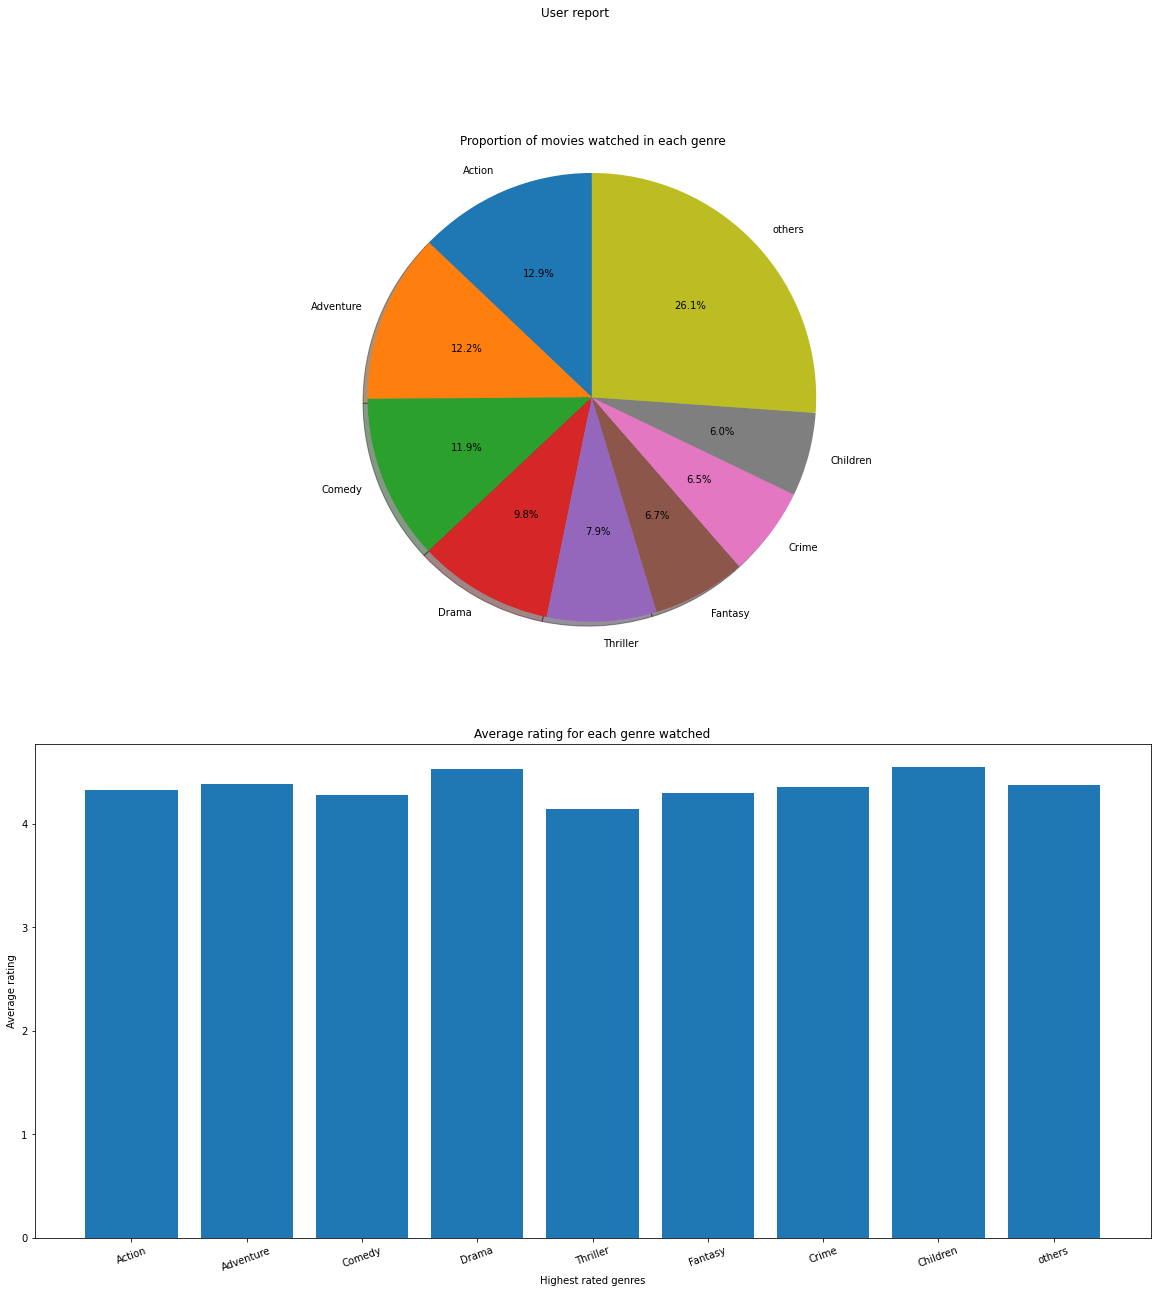

In [32]:
plotting.gen_user_report("1")

Plot the most watched movies in a given year

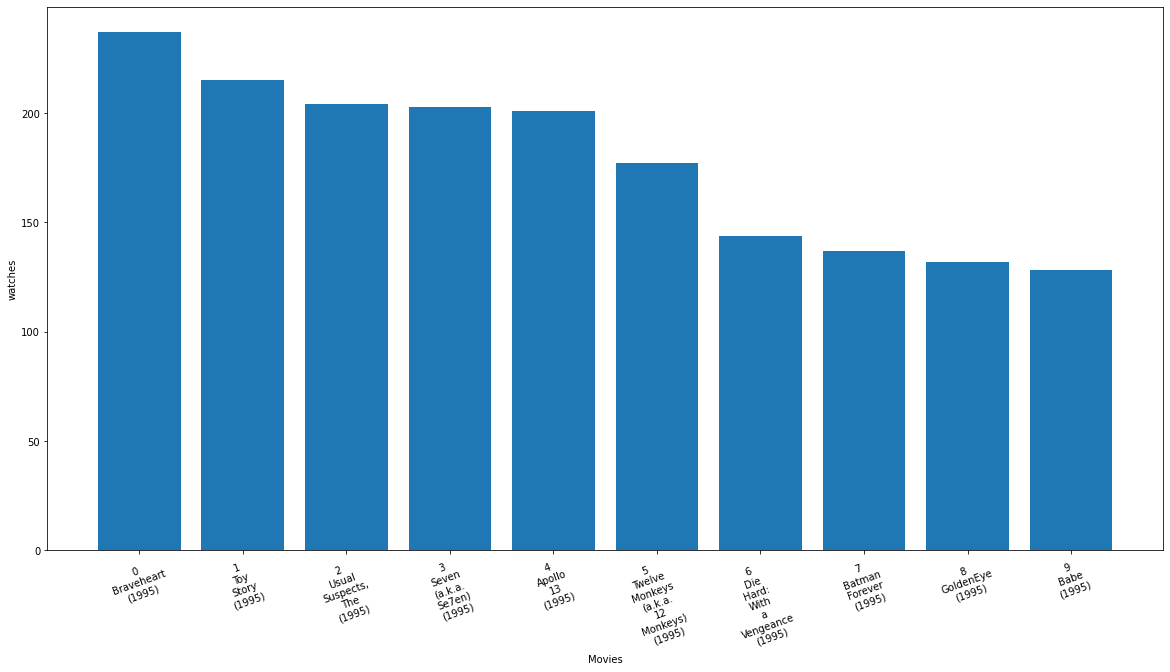

In [33]:
plotting.generic_plot(search.filter_year("1995", 10,"watches"), 'watches')

Plot the most watched movies in a given decade

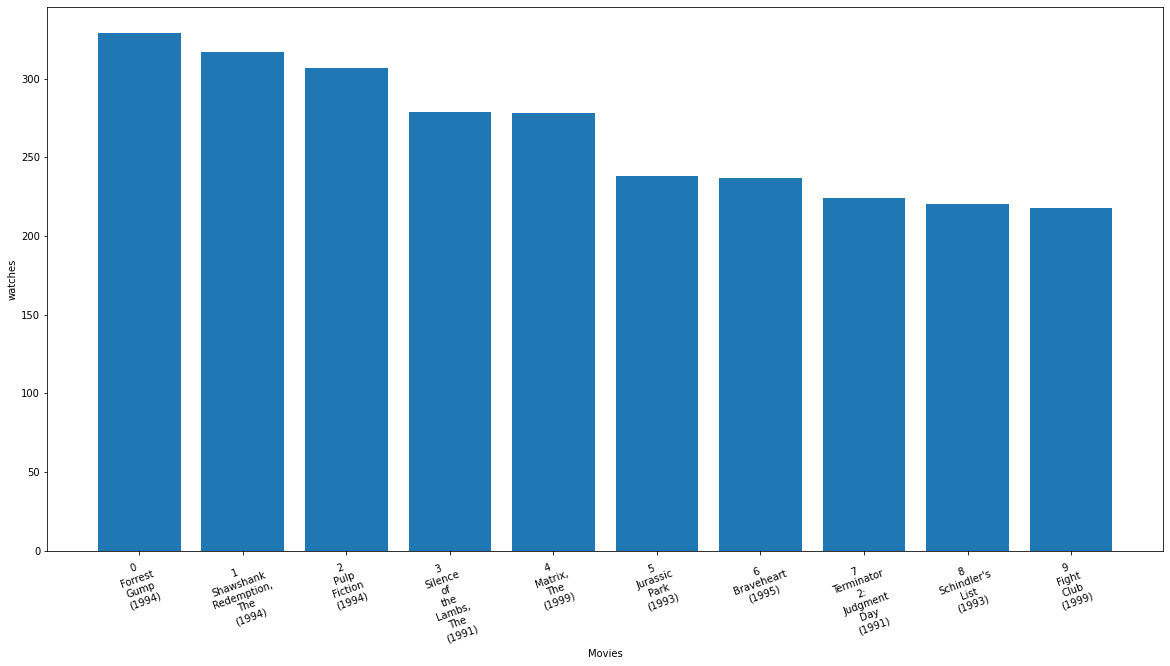

In [34]:
plotting.generic_plot(search.filter_decade("199", 10,"watches"), 'watches')

Plot the most watched movies of each decade

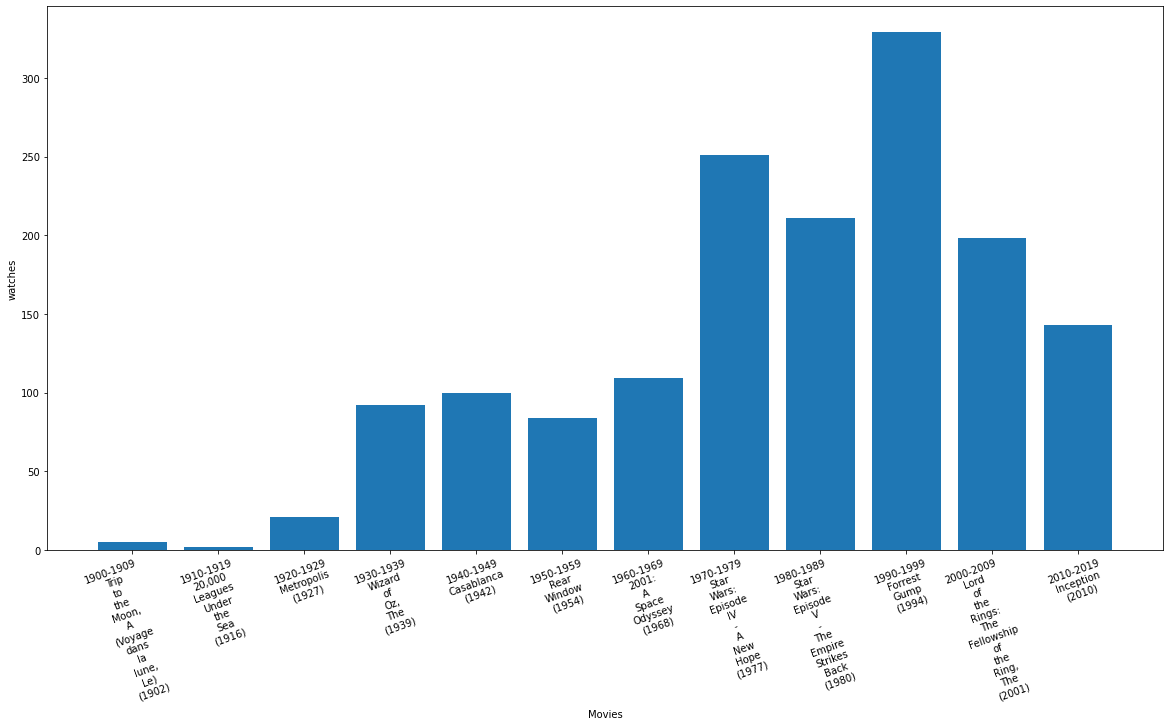

In [35]:
plotting.generic_plot(search.top_each_decade('watches'), 'watches')

Plot the most watched movies of all time

In [36]:
plotting.plot_generic_plotwatches(search.list_watches(10), 'watches')

AttributeError: 'Plotting' object has no attribute 'plot_generic_plotwatches'

Plot the highest rated movies in a given year

In [ ]:
plotting.generic_plot(search.filter_year("1995", 10,"avg(rating)"),avg(rating))

Plot the highest rated movies in a given decade

In [ ]:
plotting.generic_plot(search.filter_decade("199", 10,"avg(rating)"),avg(rating))

Plot the highest rated movies of each decade

In [ ]:
plotting.generic_plot(search.top_each_decade('avg(rating)'),avg(rating))

Plot the highest rated movies of all time

In [ ]:
plotting.generic_plot(search.list_rating(10))

In [ ]:
plotting.gen_movie_wordcloud("Pulp Fiction")

Recommend movies for a set of users using explicit feedback

In [20]:
search.recommend_n_movies_for_users(5, ["1", "3", "47", "235"]).show(truncate=False)

+------+--------------------------------------------------+---------+
|userId|title                                             |rating   |
+------+--------------------------------------------------+---------+
|1     |Top Hat (1935)                                    |6.6323805|
|1     |Passion Fish (1992)                               |6.52639  |
|1     |Baraka (1992)                                     |6.484404 |
|1     |Bourne Identity, The (1988)                       |6.370601 |
|1     |Pieces of April (2003)                            |6.2578487|
|3     |How the Grinch Stole Christmas! (1966)            |7.5964217|
|3     |Bridge to Terabithia (2007)                       |7.4332767|
|3     |Tale of Two Sisters, A (Janghwa, Hongryeon) (2003)|7.3685293|
|3     |Where the Wild Things Are (2009)                  |7.1961455|
|3     |Amityville Horror, The (1979)                     |6.9291964|
|47    |Star Wars: The Last Jedi (2017)                   |6.157513 |
|47    |Passion Fish

Recommend movies for a set of users using implicit feedback

In [21]:
search.recommend_n_movies_for_users(5, ["1", "3", "47", "235"], True).show(truncate=False)

+------+-----------------------------------------------------+-----------+
|userId|title                                                |rating     |
+------+-----------------------------------------------------+-----------+
|1     |Star Wars: Episode V - The Empire Strikes Back (1980)|1.0354899  |
|1     |Star Wars: Episode IV - A New Hope (1977)            |1.0251868  |
|1     |Jurassic Park (1993)                                 |0.99403846 |
|1     |Terminator 2: Judgment Day (1991)                    |0.96789247 |
|1     |Star Wars: Episode VI - Return of the Jedi (1983)    |0.9452278  |
|3     |RoboCop (1987)                                       |0.11178312 |
|3     |Total Recall (1990)                                  |0.105948664|
|3     |Abyss, The (1989)                                    |0.104545936|
|3     |Predator (1987)                                      |0.10399519 |
|3     |Lethal Weapon (1987)                                 |0.10202728 |
|47    |Shawshank Redempt

Evaluating the recommendation models

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = search.model_explicit.transform(search.test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error (explicit) = " + str(rmse))

predictions = search.model_implicit.transform(search.test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error (implicit) = " + str(rmse))

Root-mean-square error (explicit) = 1.0907058958697102
Root-mean-square error (implicit) = 3.2201347819164825


Cluster users by movie taste (i.e. returns the top n users with the highest similarity scores to the specified userId)

In [23]:
search.cluster("477", 3)

[('251', 0.5091007938955505),
 ('494', 0.4656758006001363),
 ('540', 0.42824901333844967)]